In [246]:
import os
import random

import numpy as np
import pandas as pd

from tensorflow import keras
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from mlp_explainer.synthetic_data import SyntheticData, split_data, sample_datapoints
from mlp_explainer.explainer import MLPExplainer

from mlp_explainer.metrics import metrics, draw_network

from pgmpy.estimators import K2

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

#### 1. Define Ground Truth Bayesian Network

In [271]:
identifier = 'experiment_1'
experiment = SyntheticData(identifier, 'discrete')

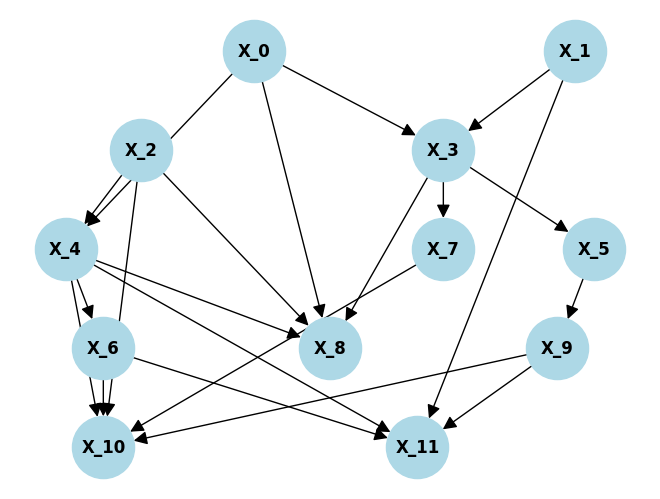

In [272]:
draw_network(experiment.model)

#### 2. Sample Sufficient Dataset From Ground Truth Bayesian Network

In [273]:
experiment.create_dataset()
experiment.save()

TypeError: Model expected type: DiscreteBayesianNetwork, got type: <class 'pgmpy.models.LinearGaussianBayesianNetwork.LinearGaussianBayesianNetwork'>

In [265]:
data = pd.read_csv(f'data/{identifier}_ground_data.csv')

In [266]:
data

,X_0,X_2,X_4,X_5,X_6,X_1,X_7,X_3
0,0,0,1,0,0,0,0,0
1,1,1,1,0,0,0,0,1
2,1,1,0,1,0,1,1,1
3,1,1,2,0,0,0,1,1
4,0,0,1,1,2,0,0,1
...,...,...,...,...,...,...,...,...
1019,0,0,1,0,2,1,0,0
1020,0,0,1,1,0,1,0,1
1021,0,1,2,0,1,0,0,0
1022,0,0,1,0,0,0,1,1


In [267]:
score = K2(data)
est = HillClimbSearch(data = data)
bn = est.estimate(scoring_method = "bic-g", max_indegree = 5, max_iter = int(1e4))

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'N', 'X_2': 'N', 'X_4': 'N', 'X_5': 'N', 'X_6': 'N', 'X_1': 'N', 'X_7': 'N', 'X_3': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'N', 'X_2': 'N', 'X_4': 'N', 'X_5': 'N', 'X_6': 'N', 'X_1': 'N', 'X_7': 'N', 'X_3': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'N', 'X_2': 'N', 'X_4': 'N', 'X_5': 'N', 'X_6': 'N', 'X_1': 'N', 'X_7': 'N', 'X_3': 'N'}


  0%|          | 0/10000 [00:00<?, ?it/s]

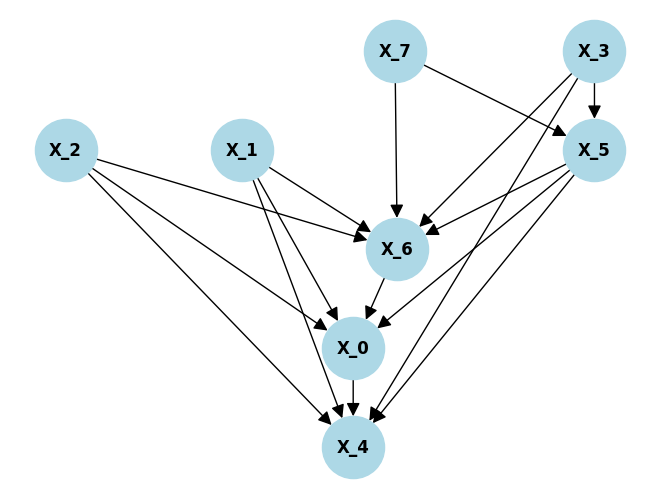

In [268]:
draw_network(bn)

In [270]:
print(experiment.model.local_independencies('X_7'))
print(bn.local_independencies('X_7'))

(X_7 ⟂ X_0, X_2 | X_6, X_3, X_4, X_5, X_1)
(X_7 ⟂ X_2, X_3, X_1)


#### 3. Choose Target Variable From Bayesian Network Variables And Preprocess Data

In [172]:
X, y, target_node = split_data(experiment.model, data)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, shuffle = True
)

In [173]:
scaler = StandardScaler()
scaler.fit(X_train)

def preprocessor(x):
    #x = scaler.transform(x_data)
    return x

In [174]:
X_train = preprocessor(X_train)
#X_val = preprocessor(X_val)
X_test = preprocessor(X_test)

y_train = keras.utils.to_categorical(y_train)
#y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

#### 4. MLP Model Building And Training

In [40]:
def build_model(n_layers = 5, n_nodes = 10, optimizer = 'adam', learning_rate = 0.001):
    
    model = keras.Sequential()
    model.add(keras.Input(shape = (X_train.shape[1],)))
    for i in range(n_layers):
        model.add(keras.layers.Dense(np.random.choice([i for i in range(n_nodes)]), activation = np.random.choice(['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(2, activation = 'softmax'))

    if optimizer == 'sgd':
        optim = keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optim = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [41]:
model = KerasClassifier(model = build_model, verbose = 0)

parameter_distribution = {
    'model__n_layers': [i for i in range(25)],
    'model__n_nodes': [i for i in range(100)],
    'model__optimizer': ['sgd', 'adam'],
    'model__learning_rate': [1e-2, 1e-3, 1e-4, 1e-5],
    'epochs': [5, 10, 15, 25, 50],
    'batch_size': [1, 2, 4, 8, 16, 32, 64, 128, 256]
}

random_search = RandomizedSearchCV(estimator = model, param_distributions = parameter_distribution, n_iter = 2, cv = 3, verbose = 1)

In [42]:
random_search.fit(X_train, y_train, validation_data = (X_val, y_val))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


,estimator,KerasClassifi..._weight=None )
,param_distributions,"{'batch_size': [1, 2, ...], 'epochs': [5, 10, ...], 'model__learning_rate': [0.1, 0.01, ...], 'model__n_layers': [0, 1, ...], ...}"
,n_iter,5
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [54]:
random_search.best_estimator_

,model,<function bui...x70d2cc7296c0>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,1
,validation_batch_size,None
,verbose,0
,callbacks,None


In [67]:
model_estimator = random_search.best_estimator_
print("Best cross-validation score:", random_search.best_score_)

Best cross-validation score: 0.5683484776024231


In [177]:
np.unique(data[target_node].to_numpy())

array([0, 1])

In [181]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_split = 0.2)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5511 - loss: 0.8904 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5679 - loss: 0.6996 - val_accuracy: 0.5549 - val_loss: 0.6888
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5756 - loss: 0.6550 - val_accuracy: 0.5671 - val_loss: 0.6820
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6305 - loss: 0.6423 - val_accuracy: 0.5366 - val_loss: 0.6872
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6550 - loss: 0.6224 - val_accuracy: 0.5610 - val_loss: 0.6813
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6550 - loss: 0.6231 - val_accuracy: 0.5488 - val_loss: 0.6841
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6473 - loss: 0.5952 - val_accuracy: 0.5488 - val_loss: 0.6829
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6260 - loss: 0.6255 - val_accuracy: 0.5671 - val_loss

In [59]:
y_pred = model.predict(X_test)
indices = np.argmax(y_pred, axis = 1)
y_pred = np.zeros_like(y_pred)
y_pred[np.arange(len(y_pred)), indices] = 1

accuracy_score(y_pred, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


0.5560975609756098

In [15]:
model_filename = os.path.join("models", f"{identifier}_model.keras")

In [16]:
model.save(model_filename)

In [17]:
from pgmpy.estimators import PC, HillClimbSearch, GES

#### 5. Generate BN Explanation

In [57]:
class MLPExplainer:
    def __init__(self, mlp):

        self.bn = None
        self.__mlp = mlp
        self.__X = None
        self.__Y = None

    def __dg_d(self, x, X_train, preprocessor, n = 10, prob = 0.5):

        samples_X = []
        samples_Y = []

        processed_x = preprocessor(x.reshape(1, -1))
        y = self.__mlp.predict(processed_x, verbose = 0)
        y = y.reshape(len(y[0]),)

        for i in range(n):
            
            # sample a random datapoint x_prime from the training set
            idx = np.random.randint(len(X_train))
            x_prime = X_train[idx]

            # replace random values in the sample with values from the original datapoint x
            mask = np.random.rand(len(x_prime)) < prob
            x_prime = np.where(mask, x, x_prime)

            # preprocess x_prime the same way as the training set and get a prediction
            processed_x_prime = preprocessor(x_prime.reshape(1, -1))
            y_prime = self.__mlp.predict(processed_x_prime, verbose = 0)
            y_prime = y_prime.reshape(len(y_prime[0]),)

            # model returns probabilities, so we have to find the class with the maximum
            # if prediction changed mask target value as 0 and 1 otherwise
            # mask values in x_prime that are different from x's as 0 and 1 otherwise
            y_prime = y_prime.argmax() == y.argmax()
            x_prime = x_prime == x

            # add masked sample and prediction to respective collections
            samples_X.append(x_prime.astype(int))
            samples_Y.append(y_prime.astype(int))

        self.__X = samples_X
        self.__Y = samples_Y

    def __vs(self):
        '''
        Variable selection.
        '''

    def __sl(self, x_cols, y_col) -> None:

        self.__X = [self.__X[i].astype(str) for i in range(len(self.__X))]
        self.__Y = [self.__Y[i].astype(str) for i in range(len(self.__Y))]
        dataframe = pd.DataFrame(self.__X, columns = x_cols)
        dataframe[y_col] = self.__Y
        print(np.unique(dataframe[y_col]))
        est = HillClimbSearch(data = dataframe)
        self.bn = est.estimate(scoring_method = "bic-g", max_indegree = 5, max_iter = int(1e4))

    def explain(self, x, X_train, preprocessor, x_cols, y_col, n, prob) -> None:

        x = np.asarray(x)
        if type(x[0]) == np.int64:
            self.__dg_d(x, X_train, preprocessor, n, prob)
        # self.__vs()
        
        self.__sl(x_cols, y_col)


In [48]:
model = keras.models.load_model(model_filename)

In [49]:
samples = sample_datapoints(X, 1)

In [52]:
explainer = MLPExplainer(model)
x_columns = data.columns.drop(target_node)

explainer.explain(
    x = samples[0], 
    X_train = X_train,
    preprocessor = preprocessor, 
    x_cols = x_columns,
    y_col = target_node,
    n = 500,
    prob = 0.0
)

y_prime: [0.548268   0.45173198]
y_prime: [0.6087629  0.39123714]
y_prime: [0.6226429 0.3773571]
y_prime: [0.61188686 0.38811308]
y_prime: [0.5839314  0.41606852]
y_prime: [0.5833144  0.41668558]
y_prime: [0.591072 0.408928]
y_prime: [0.63287586 0.36712417]
y_prime: [0.6575277  0.34247229]
y_prime: [0.5862135 0.4137864]
y_prime: [0.61188686 0.38811308]
y_prime: [0.5856587 0.4143413]
y_prime: [0.623978   0.37602204]
y_prime: [0.6222403  0.37775975]
y_prime: [0.66805106 0.33194885]
y_prime: [0.57562125 0.42437872]
y_prime: [0.61161643 0.38838354]
y_prime: [0.5508466 0.4491534]
y_prime: [0.6339189 0.3660811]
y_prime: [0.6717138  0.32828623]
y_prime: [0.61131966 0.38868028]
y_prime: [0.648543   0.35145703]
y_prime: [0.5757521  0.42424795]
y_prime: [0.59081477 0.40918517]
y_prime: [0.6160628  0.38393724]
y_prime: [0.633236   0.36676392]
y_prime: [0.63499963 0.36500034]
y_prime: [0.5775947 0.4224053]
y_prime: [0.5508466 0.4491534]
y_prime: [0.6393203  0.36067972]
y_prime: [0.57562125 0.42437

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'C', 'X_2': 'C', 'X_4': 'C', 'X_5': 'C', 'X_6': 'C', 'X_1': 'C', 'X_3': 'C', 'X_7': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'C', 'X_2': 'C', 'X_4': 'C', 'X_5': 'C', 'X_6': 'C', 'X_1': 'C', 'X_3': 'C', 'X_7': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X_0': 'C', 'X_2': 'C', 'X_4': 'C', 'X_5': 'C', 'X_6': 'C', 'X_1': 'C', 'X_3': 'C', 'X_7': 'C'}


y_prime: [0.6222403  0.37775975]
y_prime: [0.6222403  0.37775975]
['1']


  0%|          | 0/10000 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (500,2) (500,) 

#### 6. Metrics

In [ ]:
metrics(experiment.model, explainer.bn, target_node)